<a href="https://colab.research.google.com/github/Jersae/Google-TimeSeries-workshop/blob/main/TSSD_Monte_Carlo_Dropout_Predictions_with_uncertainty_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Monte Carlo Dropout

In [1]:
# Get some data
!wget -qq https://www.dropbox.com/s/5lkusg9s1rh6eaf/AirPassengers.csv
!ls

AirPassengers.csv  sample_data


In [2]:
# imports
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout



import sklearn
from sklearn.model_selection import TimeSeriesSplit

from datetime import datetime

In [3]:
df = pd.read_csv('./AirPassengers.csv')

In [4]:
print(df.shape)

df.head()

(144, 2)


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


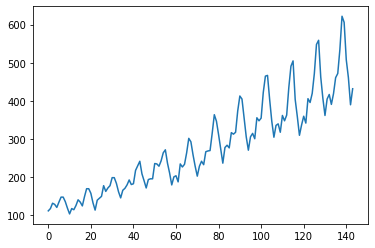

In [5]:
df['#Passengers'].plot()

In [6]:
# make a train and test split
split = int(len(df['#Passengers']) * 0.8)

dates_train, dates_test = df['Month'][:split],  df['Month'][split:]
pnum_train, pnum_test = df['#Passengers'][:split],  df['#Passengers'][split:]

pnum_train.shape, pnum_test.shape

((115,), (29,))

## Setting up a Data loader

In [7]:
window_size = 5

def create_dataset(values, window_size=10):
  # dataset = tf.expand_dims(tf.constant(values, tf.float32),axis=1)
  dataset = tf.constant(values, tf.float32)
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  dataset = dataset.window(window_size+1, shift=1 , stride=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window: ( window[:-1], window[-1] ))
  dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
  return dataset

In [8]:
train_dataset = create_dataset(pnum_train,5)
test_dataset = create_dataset(pnum_train,5)

In [9]:
train_dataset 

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>

In [10]:

Inp = tf.keras.Input(shape=(5,))
x = Dense(128)(Inp)
x = Dropout(0.3)(x, training=True) # here we are setting it so Dropout is always on
x = Dense(128)(Inp)
outputs = Dropout(0.3)(x, training=True) # Again leaving dropout on in predictions
new_output = Dense(1)(outputs)

model = tf.keras.Model(Inp, new_output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='mae',
              optimizer='adam',
              metrics=['mae'])

In [12]:
model.fit(train_dataset,
          epochs=250)

Epoch 1/250
4/4 [==============================] - 1s 15ms/step - loss: 151.5491 - mae: 151.5491
Epoch 2/250
4/4 [==============================] - 0s 7ms/step - loss: 98.7901 - mae: 98.7901
Epoch 3/250
4/4 [==============================] - 0s 6ms/step - loss: 51.3513 - mae: 51.3513
Epoch 4/250
4/4 [==============================] - 0s 9ms/step - loss: 72.0836 - mae: 72.0836
Epoch 5/250
4/4 [==============================] - 0s 3ms/step - loss: 74.2771 - mae: 74.2771
Epoch 6/250
4/4 [==============================] - 0s 5ms/step - loss: 68.4146 - mae: 68.4146
Epoch 7/250
4/4 [==============================] - 0s 6ms/step - loss: 59.2846 - mae: 59.2846
Epoch 8/250
4/4 [==============================] - 0s 7ms/step - loss: 47.5380 - mae: 47.5380
Epoch 9/250
4/4 [==============================] - 0s 6ms/step - loss: 54.5823 - mae: 54.5823
Epoch 10/250
4/4 [==============================] - 0s 6ms/step - loss: 57.9024 - mae: 57.9024
Epoch 11/250
4/4 [==============================] - 0s 4

### Predictions

In [13]:


predictions = []

sample_size = 100
for t in range(sample_size):
    predictions.append(model.predict(test_dataset))



In [14]:
prediction_df = pd.DataFrame()
pred_array = np.array(predictions)

prediction_df['mean'] = pred_array.mean(axis=0).reshape(-1,)
prediction_df['std'] = pred_array.std(axis=0).reshape(-1,)

In [15]:
predictions[0].shape

(110, 1)

In [16]:
predictions[0:20]

[array([[113.740135],
        [119.67888 ],
        [130.53642 ],
        [161.10016 ],
        [128.27466 ],
        [103.5931  ],
        [113.83573 ],
        [121.55425 ],
        [110.40364 ],
        [139.9671  ],
        [144.61908 ],
        [119.517555],
        [137.3841  ],
        [134.79085 ],
        [188.19173 ],
        [175.31738 ],
        [143.9438  ],
        [132.47643 ],
        [108.4485  ],
        [144.91348 ],
        [158.3753  ],
        [170.2358  ],
        [193.20256 ],
        [159.61438 ],
        [183.4989  ],
        [166.09296 ],
        [201.18053 ],
        [206.87402 ],
        [172.92015 ],
        [129.4652  ],
        [136.2386  ],
        [188.57094 ],
        [192.99579 ],
        [163.04639 ],
        [178.40424 ],
        [180.93054 ],
        [170.62976 ],
        [217.10168 ],
        [233.99492 ],
        [217.84103 ],
        [197.30894 ],
        [190.34358 ],
        [171.54514 ],
        [215.48965 ],
        [205.63545 ],
        [2

In [17]:
prediction_df[:20]

,mean,std
0,117.115524,7.766126
1,133.079330,9.943834
2,150.119522,9.601656
3,148.212814,9.768576
4,129.196808,8.067664
5,111.240875,7.661840
6,103.047470,8.176453
7,127.733513,8.177647
8,119.216248,7.502194
9,136.451859,8.794561


## Ploting the preds with error bars and fills


In [18]:
x = list(range(0,prediction_df.shape[0]))
prediction_df.shape

(110, 2)

In [19]:
mean = prediction_df['mean']
std = prediction_df['std']

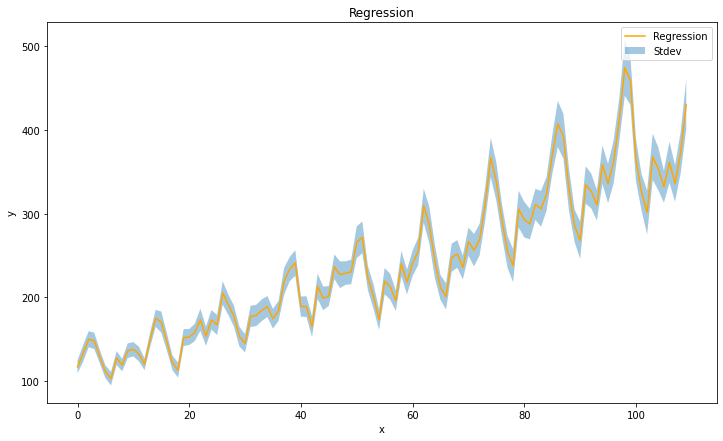

In [20]:

plt.figure(figsize=(12, 7))
plt.plot(x, prediction_df['mean'], label='Regression', c='orange')
# plt.errorbar(x, prediction_df['mean'], prediction_df['std'], linestyle='None', marker='.')
plt.fill_between(x, mean-std, mean+std, label='Stdev', alpha=0.4)
plt.title('Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

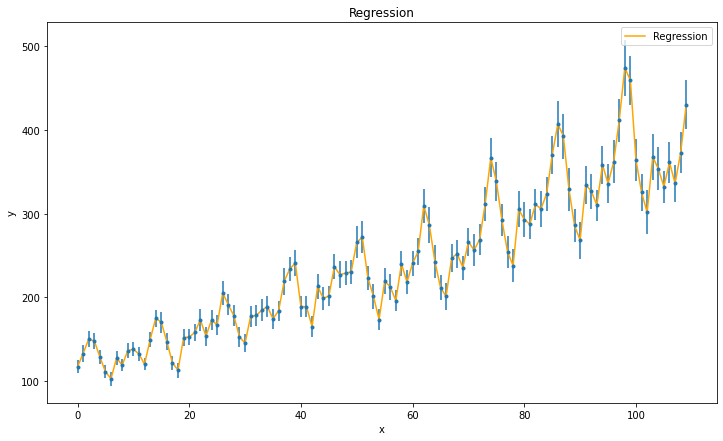

In [21]:


plt.figure(figsize=(12, 7))
plt.plot(x, prediction_df['mean'], label='Regression', c='orange')
plt.errorbar(x, prediction_df['mean'], prediction_df['std'], linestyle='None', marker='.')
plt.title('Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()